Mounted at /content/drive
1/1 [==============================] - 4s 4s/step
PSNR: 13.324983596801758, SSIM: 0.533466100692749


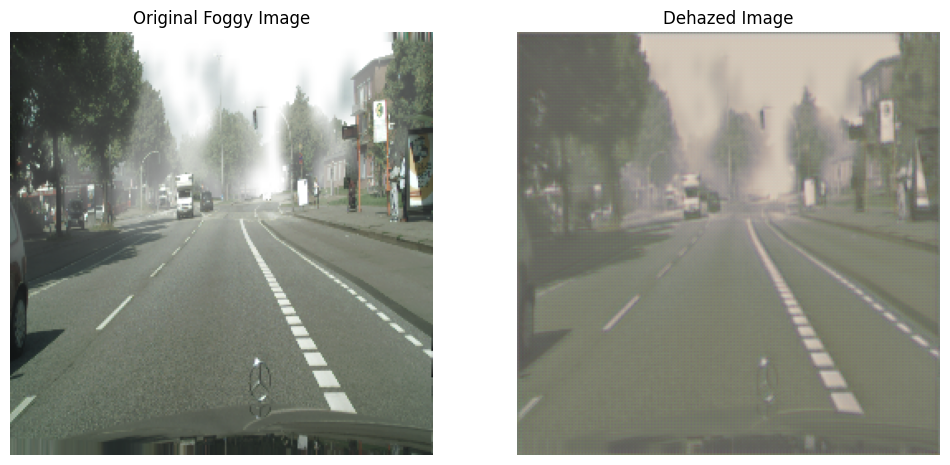

1/1 [==============================] - 2s 2s/step
PSNR: 11.819567680358887, SSIM: 0.5085418224334717


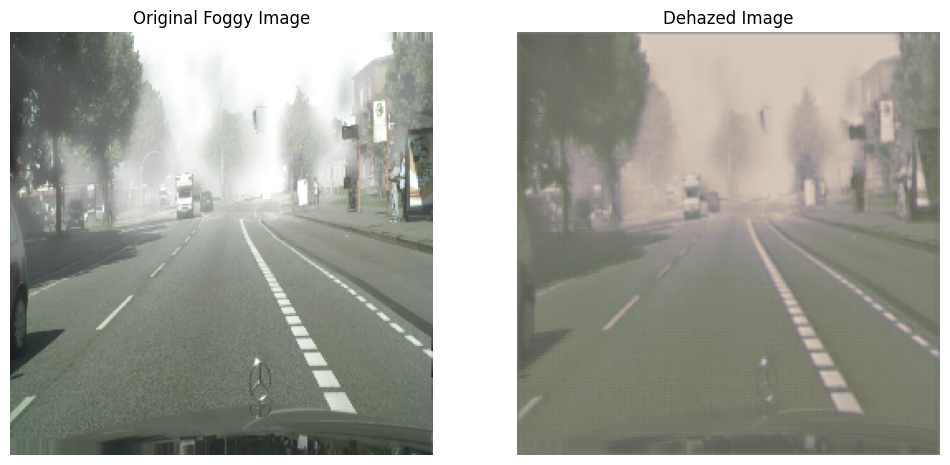

1/1 [==============================] - 3s 3s/step
PSNR: 10.147113800048828, SSIM: 0.47628843784332275


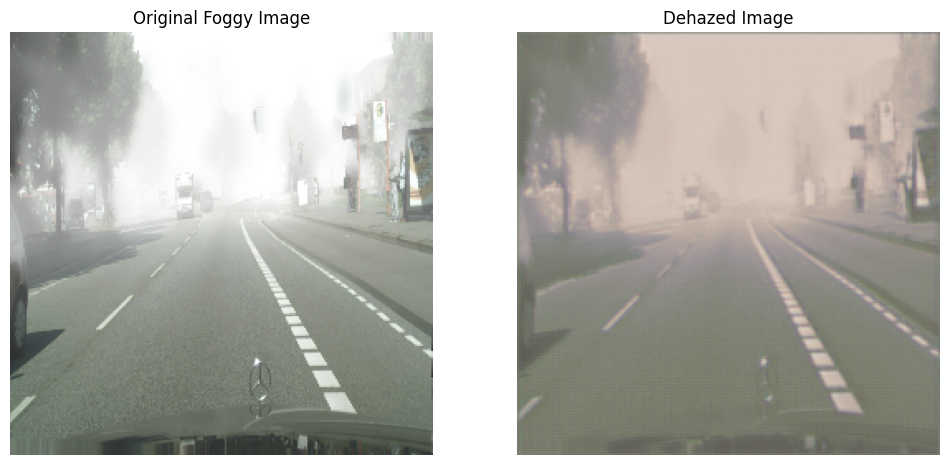

1/1 [==============================] - 2s 2s/step
PSNR: 13.424372673034668, SSIM: 0.42861953377723694


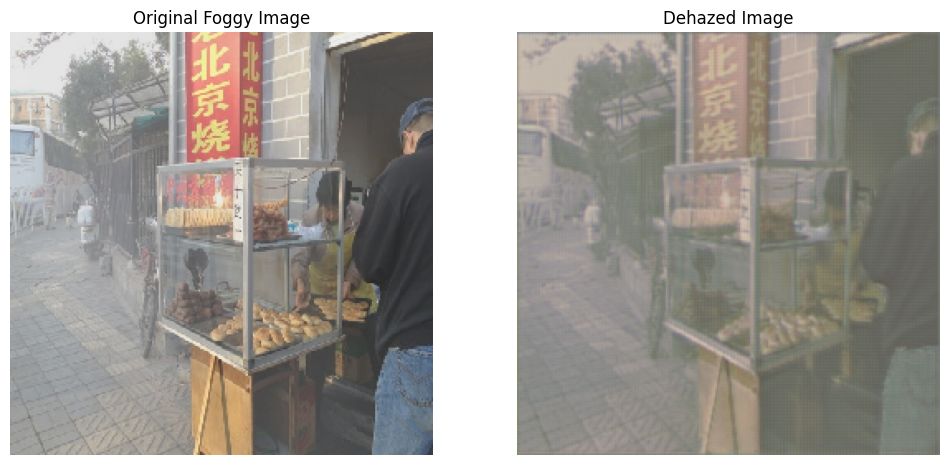

1/1 [==============================] - 2s 2s/step
PSNR: 14.206618309020996, SSIM: 0.5786767601966858


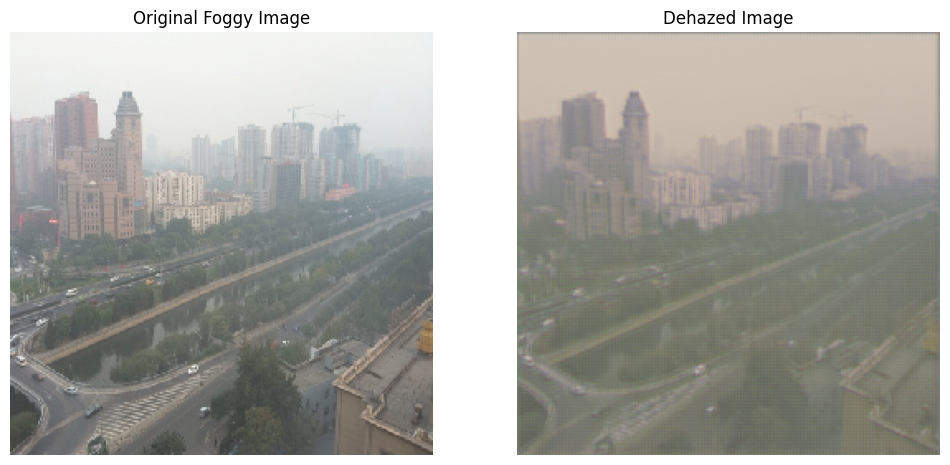

1/1 [==============================] - 3s 3s/step
PSNR: 15.430765151977539, SSIM: 0.568873405456543


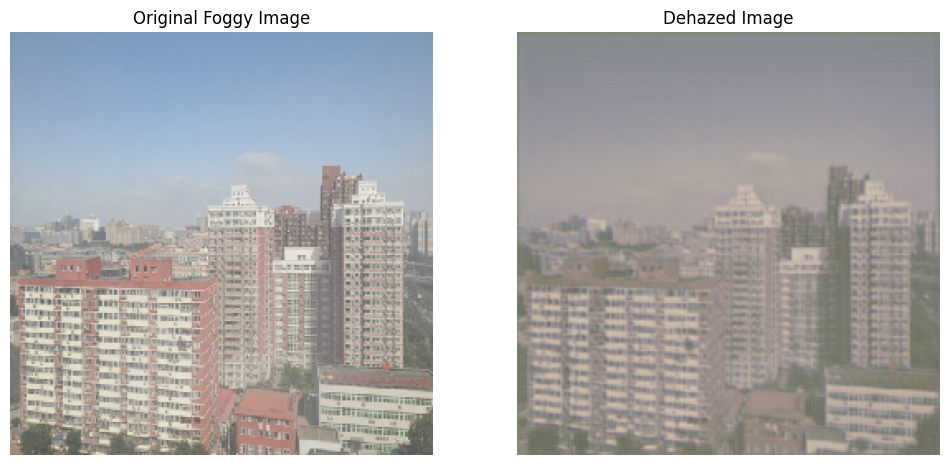

1/1 [==============================] - 2s 2s/step
PSNR: 13.63737964630127, SSIM: 0.620553731918335


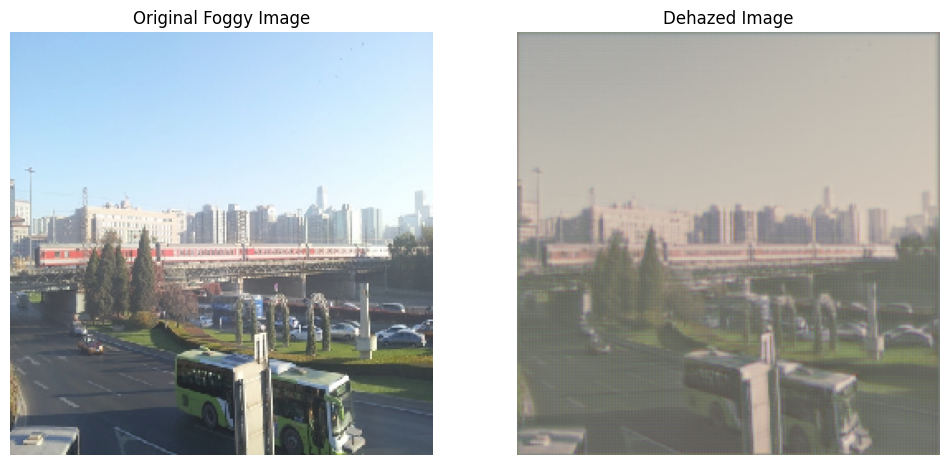

                                               Image       PSNR      SSIM
0  hamburg_000000_000042_leftImg8bit_foggy_beta_0...  13.324984  0.533466
1  hamburg_000000_000042_leftImg8bit_foggy_beta_0...  11.819568  0.508542
2  hamburg_000000_000042_leftImg8bit_foggy_beta_0...  10.147114  0.476288
3                                  0182_0.8_0.16.jpg  13.424373  0.428620
4                                  0100_0.9_0.12.jpg  14.206618  0.578677
5                                   0001_0.8_0.2.jpg  15.430765  0.568873
6                                    0391_1_0.08.jpg  13.637380  0.620554


In [1]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import psnr, ssim
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import save_img
import numpy as np
from tensorflow.keras.losses import MSE

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import psnr, ssim
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.models import Model
import pandas as pd

from tensorflow.keras.applications import VGG19
from tensorflow.keras.losses import MSE, MeanSquaredError
import tensorflow.keras.backend as K

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

def psnr_metric(y_true, y_pred):
    """PSNR Metric."""
    return psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03):
    """
    SSIM Metric with adjustable parameters.
    Returns:
    - SSIM index between y_true and y_pred.
    """
    return tf.image.ssim(y_true, y_pred, max_val=max_val, filter_size=filter_size, filter_sigma=filter_sigma, k1=k1, k2=k2)

# Load the trained model from the file with custom_objects
model_path = '/content/drive/My Drive/diss/myproj/results/3_6VGG19LossMSEModResFog.keras'

from tensorflow.keras.applications import VGG19
from tensorflow.keras.losses import MSE, MeanSquaredError
import tensorflow.keras.backend as K

# Load VGG19 model for perceptual loss, excluding the top fully connected layers
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
vgg.trainable = False

# Select the output layer for feature extraction
output_layer = vgg.get_layer('block2_conv2').output
vgg_model = Model(inputs=vgg.input, outputs=output_layer)

def perceptual_loss(y_true, y_pred):
    """
    Calculates the perceptual loss between y_true and y_pred using the VGG19 model.
    """
    vgg_true = vgg_model(y_true)
    vgg_pred = vgg_model(y_pred)
    return K.mean(K.square(vgg_true - vgg_pred))


# Initialize Mean Squared Error loss instance
mse_loss = MeanSquaredError()

def custom_loss(y_true, y_pred):
    """
    Custom loss function that combines MSE and perceptual loss,
    with explicit type casting for mixed precision compatibility.
    """
    mse = mse_loss(y_true, y_pred)
    p_loss = perceptual_loss(y_true, y_pred)

    # Ensure both mse and p_loss are float32 before addition
    mse = tf.cast(mse, 'float32')
    p_loss = tf.cast(p_loss, 'float32')

    return mse + p_loss


# Then, include it in the custom_objects dictionary
custom_objects = {
    "psnr_metric": psnr_metric,
    "ssim_metric": ssim_metric,
    "custom_loss": custom_loss  # Add your custom loss function here
}
from keras.utils import custom_object_scope
# Register the perceptual_loss function for serialization
with custom_object_scope({'perceptual_loss': perceptual_loss}):
    # Load the model with custom_objects
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# # Load the model with custom_objects
# model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# Define paths to images
image_paths = [
    "/content/drive/My Drive/diss/myproj/data_test/test/hamburg_000000_000042_leftImg8bit_foggy_beta_0.005.png",
    "/content/drive/My Drive/diss/myproj/data_test/test/hamburg_000000_000042_leftImg8bit_foggy_beta_0.01.png",
    "/content/drive/My Drive/diss/myproj/data_test/test/hamburg_000000_000042_leftImg8bit_foggy_beta_0.02.png",


    "/content/drive/My Drive/diss/myproj/data_test/test/0182_0.8_0.16.jpg",
    "/content/drive/My Drive/diss/myproj/data_test/test/0100_0.9_0.12.jpg",
    "/content/drive/My Drive/diss/myproj/data_test/test/0001_0.8_0.2.jpg",
    "/content/drive/My Drive/diss/myproj/data_test/test/0391_1_0.08.jpg"
]

# Define paths for saving results
save_paths = [

    "/content/drive/My Drive/diss/myproj/results/images/hamburg_000000_000042_leftImg8bit_foggy_beta_0.005.png",
    "/content/drive/My Drive/diss/myproj/results/images/hamburg_000000_000042_leftImg8bit_foggy_beta_0.01.png",
    "/content/drive/My Drive/diss/myproj/results/images/hamburg_000000_000042_leftImg8bit_foggy_beta_0.02.png",


    "/content/drive/My Drive/diss/myproj/results/images/0182_0.8_0.16.jpg",
    "/content/drive/My Drive/diss/myproj/results/images/0100_0.9_0.12.jpg",
    "/content/drive/My Drive/diss/myproj/results/images/0001_0.8_0.2.jpg",
    "/content/drive/My Drive/diss/myproj/results/images/0391_1_0.08.jpg"
]


ground_truth_image_path = [

    "/content/drive/My Drive/diss/myproj/data_test/test/clear/hamburg_000000_000042_leftImg8bit.png",
    "/content/drive/My Drive/diss/myproj/data_test/test/clear/hamburg_000000_000042_leftImg8bit.png",
    "/content/drive/My Drive/diss/myproj/data_test/test/clear/hamburg_000000_000042_leftImg8bit.png",

    "/content/drive/My Drive/diss/myproj/data_test/test/clear/0182.png",
    "/content/drive/My Drive/diss/myproj/data_test/test/clear/0100.png",
    "/content/drive/My Drive/diss/myproj/data_test/test/clear/0001.png",
    "/content/drive/My Drive/diss/myproj/data_test/test/clear/0391.png"
]

# Initialize a list to hold the results
results = []

# Loop through each image path along with its corresponding save path and ground truth image path
for image_path, save_path, gt_path in zip(image_paths, save_paths, ground_truth_image_path):
    # Load and preprocess the image
    foggy_image = load_img(image_path, target_size=(256, 256))
    foggy_image_array = img_to_array(foggy_image) / 255.0
    foggy_image_array = np.expand_dims(foggy_image_array, axis=0)  # Add batch dimension

    # Predict the dehazed image
    dehazed_image_array = model.predict(foggy_image_array)
    dehazed_image = dehazed_image_array[0]  # Remove batch dimension for display

    # Save the dehazed image
    save_img(save_path, dehazed_image * 255.0)  # Un-normalize the pixel values for saving

    # Load and preprocess the ground truth image
    ground_truth_image = load_img(gt_path, target_size=(256, 256))
    ground_truth_image_array = img_to_array(ground_truth_image) / 255.0

    # Compute PSNR and SSIM
    psnr_value = psnr_metric(ground_truth_image_array, dehazed_image).numpy()
    ssim_value = ssim_metric(ground_truth_image_array, dehazed_image, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

    print(f"PSNR: {psnr_value}, SSIM: {ssim_value}")

    # Append results to the results list
    results.append({
        "Image": image_path.split('/')[-1],  # Just the filename for readability
        "PSNR": psnr_value,
        "SSIM": ssim_value
    })

    # Display the original and dehazed images for comparison
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(foggy_image_array[0])
    plt.title("Original Foggy Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(dehazed_image)
    plt.title("Dehazed Image")
    plt.axis('off')

    plt.show()

# Create a DataFrame
df_results = pd.DataFrame(results)

# Print the DataFrame to display the table
print(df_results)

# Write results to a text file
with open('/content/drive/My Drive/diss/myproj/results/dehazing_results.txt', 'w') as file:
    file.write("Image Results:\n")
    for result in results:
        file.write(f"Image: {result['Image']}, PSNR: {result['PSNR']:.2f}, SSIM: {result['SSIM']:.4f}\n")
